In [ ]:
pip3 install beautifulsoup4 requests

In [59]:
import sys
import requests
from bs4 import BeautifulSoup
import re, string
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import datetime

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [9]:
def getResults(my_search_term, page=1):
    
    html = requests.get(f"https://apnews.com/search?q={my_search_term}&p={page}")
    soup = BeautifulSoup(html.content, "html.parser")
    
    body = soup.find("div", class_="SearchResultsModule-results")
    results = [div.get_text(strip=True) for div in body.find_all("div", class_="PagePromo-description")]
    
    # Don't worry about dates for now. We will use them in Problem 4.4
    dates = [div.find('bsp-timestamp')['data-timestamp'] for div in soup.find_all("div", class_="PagePromo-date")]
    
    return results, dates  

In [63]:
my_search_term = "Broncos" # Replace this with your chosen search term! 

In [64]:
results, _ = getResults(my_search_term, 1)
results[0]

'Week 6 pits two of the league’s stingiest defenses when the Los Angeles Chargers visit the Denver Broncos on Sunday.'

In [66]:
def preProcess(result):
 
    result = re.sub(r'\b\d+\b', '', result)

    result = re.sub(r'[^\w\s]', '', result)

    result = result.lower()

    processedResult = result.split()
        
    return processedResult

In [67]:
preProcess(results[np.random.randint(0,30)])

['the',
 'denver',
 'broncos',
 'and',
 'los',
 'angeles',
 'chargers',
 'have',
 'a',
 'long',
 'history',
 'of',
 'offensive',
 'shootouts',
 'going',
 'back',
 'to',
 'the',
 'air',
 'coryell',
 'era',
 'of',
 'the',
 'american',
 'football',
 'league']

In [68]:
def searchTerm(my_search_term):
    
    processedResults = []
    allDates = []
    page = 1
    
    while len(processedResults) < 100:
        
        currResults, currDates = getResults(my_search_term, page)
        
        for i, result in enumerate(currResults):
            processed = preProcess(result)
            
            if processed not in processedResults:
                processedResults.append(processed)  
                allDates.append(currDates[i]) 

                
                if len(processedResults) >= 100:
                    break
        
        
        page += 1
    
    
    return processedResults, allDates[:100]

Select your search term to test the functions.
> **Hint**: Make sure this works before you continue. Look at the returned data, its type, length, and _some_ of its entries. **Best Practice**: Do not print out the entire data in the version of the notebook that you submit/deploy/share. 

In [69]:
data, dates = searchTerm(my_search_term) # feel free to go change this above!

In [70]:
def analyzeSentiment(entry):
    
    sentimentScore = 0

    for word in entry:
        if word in positive_words:
            sentimentScore += 1
        
        if word in negative_words:
            sentimentScore -= 1

    if sentimentScore >= 0:
        return 1
    else:
        return -1
        

Now, we can run all out tweets through this function and collect their sentiment. 

In [71]:
sentiments = []

global negative_words
global positive_words

with open('utility/data/negative-words.txt') as f:
    negative_words = [word.strip() for word in f.readlines() if word[0] not in [';', '\n']]

with open('utility/data/positive-words.txt') as f:
    positive_words = [word.strip() for word in f.readlines() if word[0] not in [';', '\n']]
    
for entry in data:
    sentiments.append(analyzeSentiment(entry))
sentiment_labels = np.array(sentiments)    
    
sentiment_labels

array([ 1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1])

74
26


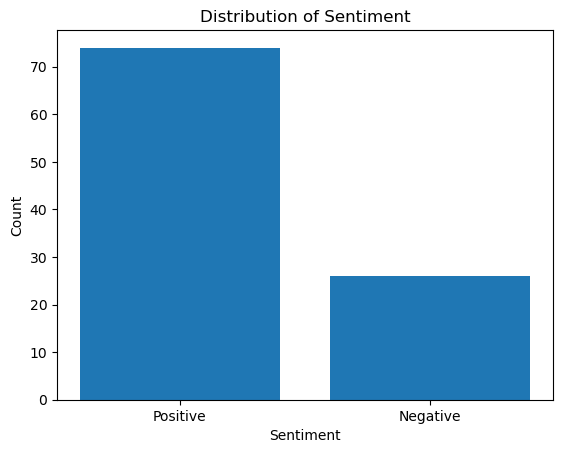

In [72]:
# Let's run a configuration to make prettier plots
plt.rcdefaults()

totalPos = sum(sentiment_labels == 1)
totalNeg = sum(sentiment_labels == -1)

print(totalPos)
print(totalNeg)

plt.bar(['Positive', 'Negative'], [totalPos, totalNeg])
plt.title("Distribution of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

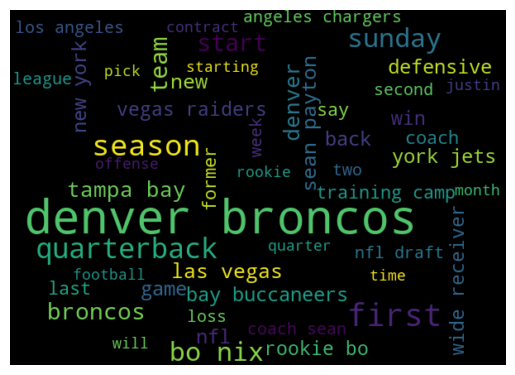

In [73]:
def get_all_words(data2plot):
    
    overallWords = ' '

    for entry in data2plot:
        for word in entry:
            overallWords += word + ' '

    return overallWords

wordcloud = WordCloud(width=600, height=430, max_words=50).generate(get_all_words(data))

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [74]:
positive_data = [i for indx,i in enumerate(data) if sentiments[indx] == 1]

negative_data = [i for indx,i in enumerate(data) if sentiments[indx] == -1]

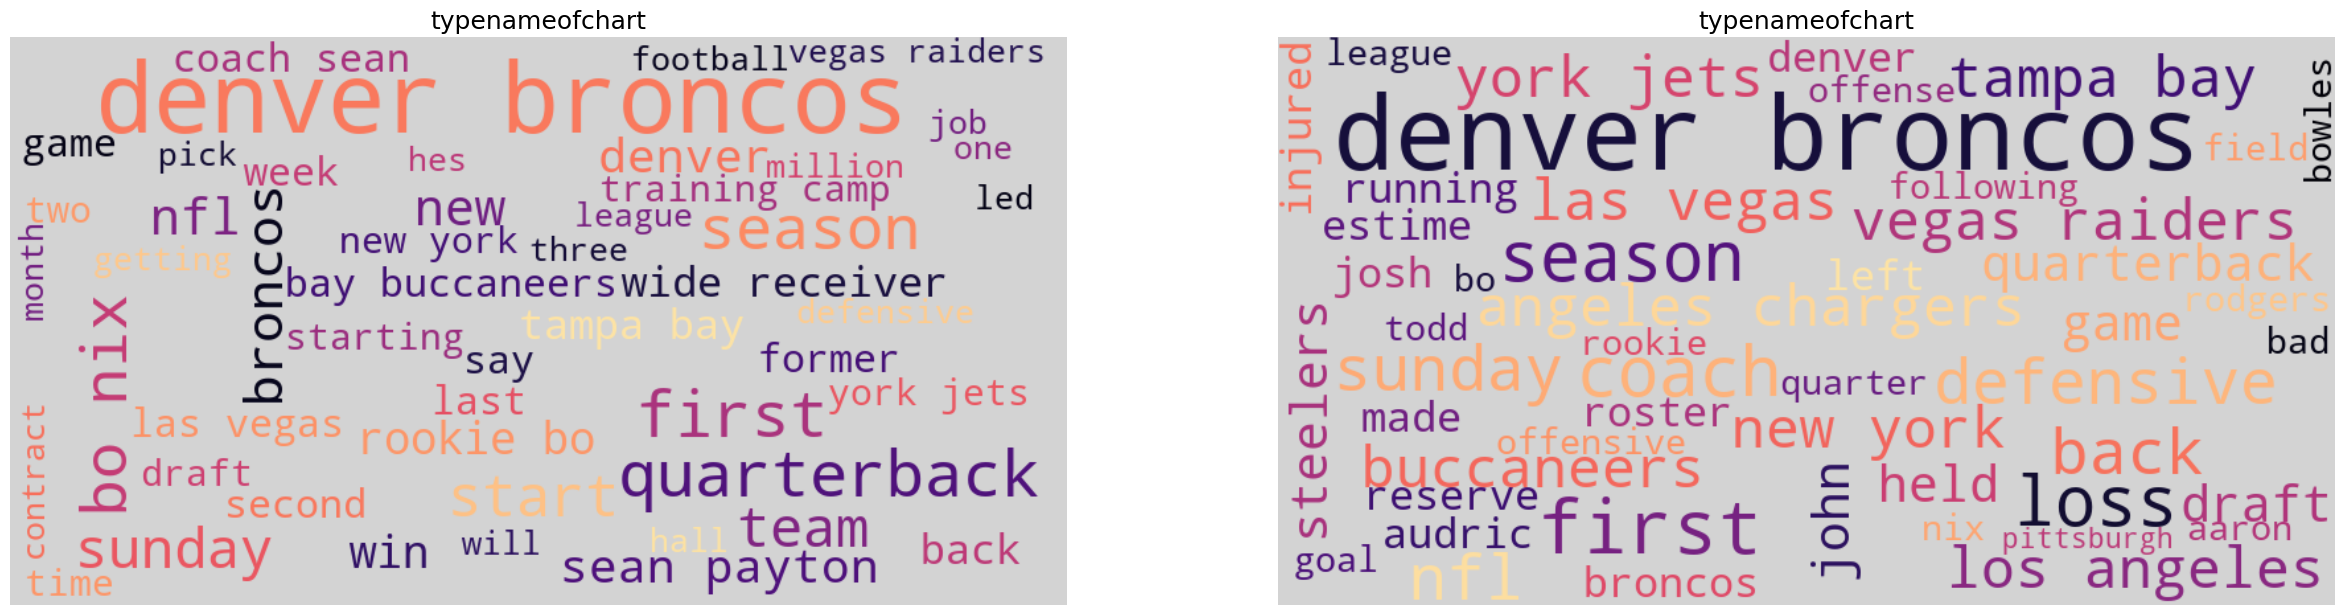

In [75]:
plt.figure(figsize=(30,15))
plt.subplot(121)
wordcloud = WordCloud(width=800, height=430, max_words=50, background_color='lightgray',colormap='magma').generate(get_all_words(positive_data))
plt.title("typenameofchart", fontsize=18)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


plt.subplot(122)

wordcloud = WordCloud(width=800, height=430, max_words=50,background_color= 'lightgray', colormap='magma').generate(get_all_words(negative_data))
plt.title("typenameofchart", fontsize=18)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


plt.show()

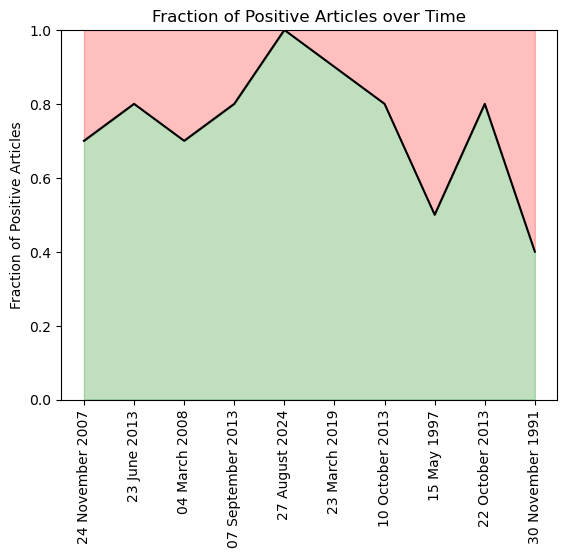

In [76]:
full_data = zip(data, sentiment_labels, dates)
sortData = sorted(full_data,key=lambda x:x[2])

k = 10
bin_size = [sortData[i:i+k] for i in range(0,len(sortData),k)]

fracs_pos = []
average_dates = []

for entry in bin_size:
    frac_pos = 0
    time=0
    for article in entry:
        if article[1]== 1:
            frac_pos+=1
            time += int(article[2])

    fracs_pos.append(frac_pos/k)
    average_dates.append(int(time/k))

    
plt.plot(range(k), fracs_pos, c='black')
plt.xticks(range(k), [datetime.datetime.fromtimestamp(d/1000).strftime("%d %B %Y") for d in average_dates], rotation = 90)
plt.ylabel('Fraction of Positive Articles')
plt.title('Fraction of Positive Articles over Time')
plt.ylim(0, 1)
plt.fill_between(range(k), 1, fracs_pos, where=fracs_pos, color='red', alpha=0.25)
plt.fill_between(range(k), 0, fracs_pos, where=fracs_pos, color='green', alpha=0.25)

plt.show()  

The overall sentiment was that 74% was positive while 26% was negative. Some of the most frequent words that were used were Denver, rookie, and Bo. Denver was frequently used because that is the location of the Broncos team. The word rookie is constantly used because their starting quarterback is a rookie. The word Bo is constantly used because that is the first name of the starting quarterback. The words new and win were some of the least frequent words used because the most of the articles don't really describe wins and losses; rather, the dynamic of games and the team, besides their quarterback, kept everything else relatively similar. I believe that the words rookie used frequently may contribute to positive sentiment because it may, in this case, signify a fresh start for something new. Also, the words new and win will heavily contribute because they also connnotate something positive in football terminology. 

The sentiment on my chosen term, Broncos, increases over time. For instance, the positive sentiment was about .4-.5 in the 1991 and 1998 articles, then increases to .75-.8 in the 2007 and 2008 articles, then jumps to surprisingly a 1.0 (fully positive) article in the most recent article in 2024. I believe this is the case because the Denver Broncos have been an average franchise in the past. However, as time went on, the team slowly started improving. Currently, the Broncos are in the best shape in the last 20 years, which may be the biggest reason why the sentiment is at its highest right now and has been increasing over time.  

One specific thing from my analysis that I found particularly interesting is that the most frequent words that came up were neither positive or negative. I assumed that the most common terms would be positive or negative considering that there are many emotion based words in sports articles. However, the most common words being the location and the rookie quartback's name, which definitely don't have a positive or negative dictionary definition. 